In [1]:
import math
import numpy as np
import pandas as pd
from PIL import Image
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
img = Image.open("images/mtf.jpg").convert("L")
arr = np.array(img)
h, w = arr.shape
h, w

(457, 1034)

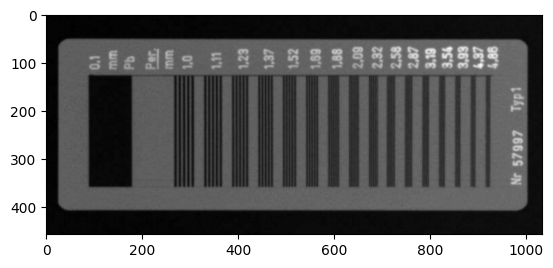

In [3]:
display(arr, axis=True)

In [4]:
hp = int(0.26*h)
wp = int(0.02*w)

In [5]:
focus_l = arr[: hp, wp*10: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(118, 20)

In [6]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by row
    Return: argdiff in len(rows)
    """
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [7]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

50

In [8]:
focus_r = arr[: hp, w-(wp*11): w-(wp*10)]
nrows, ncols = focus_r.shape
nrows, ncols

(118, 20)

In [9]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

52

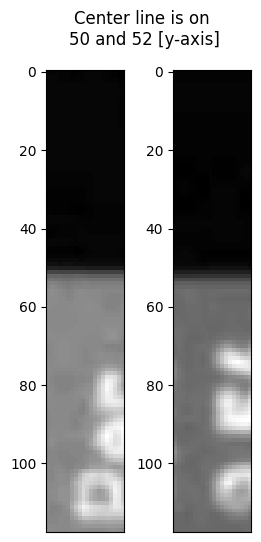

In [10]:
plt.figure(figsize=(3, 6))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [11]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.asin(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [12]:
theta = find_theta(w, y1, y2)
theta

0.11082362715595355

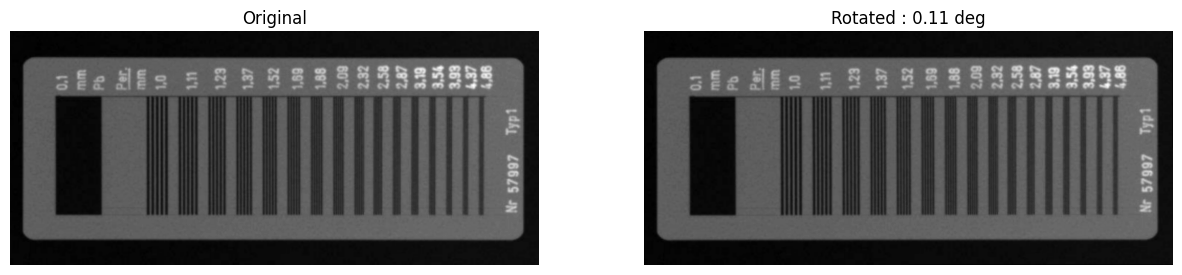

In [13]:
rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [14]:
h, w = rotate_img.shape
h, w

(457, 1034)

In [15]:
hp = int(0.11*h)
wp = int(0.05*w)

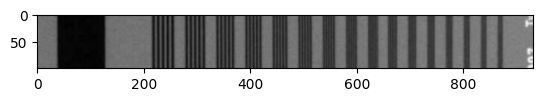

In [16]:
focus = rotate_img[h//2-hp: h//2+hp, wp: w-wp]
display(focus, True)

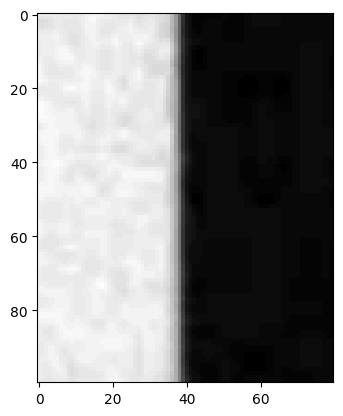

In [17]:
wpf = int(0.086*focus.shape[1])
display(focus[:, :wpf], True)

In [18]:
white = round(np.min(focus[:, :wpf//3]))
black = round(np.min(focus[:, (wpf//3)*2:wpf]))
white, black

(100, 48)

In [19]:
mean_max_vals0, mean_min_vals0 = round(np.mean(focus[:, :wpf//3])), round(np.mean(focus[:, (wpf//3)*2:wpf]))
max_ref = abs(mean_max_vals0 - mean_min_vals0)
max_ref

54

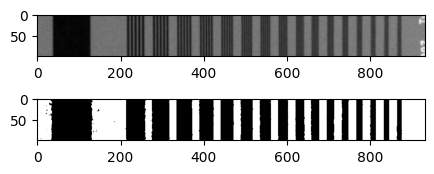

In [20]:
threshold = white
binary_image = np.where(focus <= threshold, 0, 255)

plt.figure(figsize=(5, 2))
plt.subplot(2, 1, 1)
display(focus, True)

plt.subplot(2, 1, 2)
display(binary_image, True)

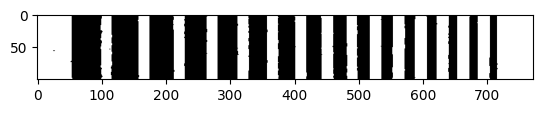

In [21]:
# find position to determined line pairs
linepairs = binary_image[:, wpf*2:]
display(linepairs, True)

In [22]:
locate = np.median(linepairs, axis=0)
locate[:200]

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
       255., 255., 255., 255., 255., 255.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [23]:
arg_locates = []
s1, s2 = None, None
find_start = True # find first zero to determined area
for idx, val in enumerate(locate) :
    if find_start :
        if val == 0.0 :
            s1 = idx
            find_start = False
            arg_locates.append(s1)
    else :
        if val == 255.0 :
            find_start = True
            s2 = idx 
            arg_locates.append(s2)

In [24]:
trim = int(0.004*len(locate))
pairs = [(arg_locates[i]+trim, arg_locates[i + 1]-trim) for i in range(0, len(arg_locates) - 1, 2)]
pairs

[(57, 97),
 (119, 155),
 (178, 210),
 (233, 261),
 (284, 309),
 (333, 355),
 (378, 399),
 (422, 440),
 (464, 479),
 (501, 515),
 (539, 551),
 (575, 585),
 (610, 619),
 (644, 651),
 (676, 683),
 (708, 713)]

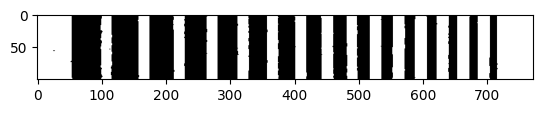

In [25]:
display(linepairs, True)

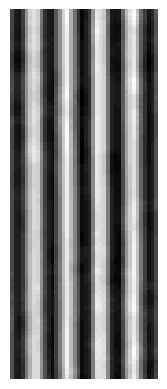

In [26]:
focus = focus[:, wpf*2:]
display(focus[:, pairs[0][0]: pairs[0][1]])

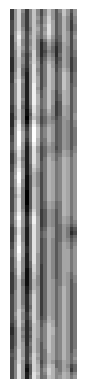

In [27]:
display(focus[:, pairs[7][0]: pairs[7][1]])

In [28]:
res = {"Linepair": [0], "Max": [mean_max_vals0], "Min": [mean_min_vals0], "Contrast": [max_ref], "Modulation": [100]}
for idx, (s1, s2) in enumerate(pairs, start=1) :
    linepair = focus[:, s1: s2]
    mean_val_col = np.mean(linepair, axis=0)
    sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    mid_pos = min((s2-s1)//2, int(.3*(s2-s1))) # how to select actual value
    mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    contrast = mean_max_vals-mean_min_vals
    res["Linepair"].append(idx)
    res["Max"].append(mean_max_vals)
    res["Min"].append(mean_min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round((mean_max_vals-mean_min_vals)*100/max_ref, 3))
res = pd.DataFrame(res)

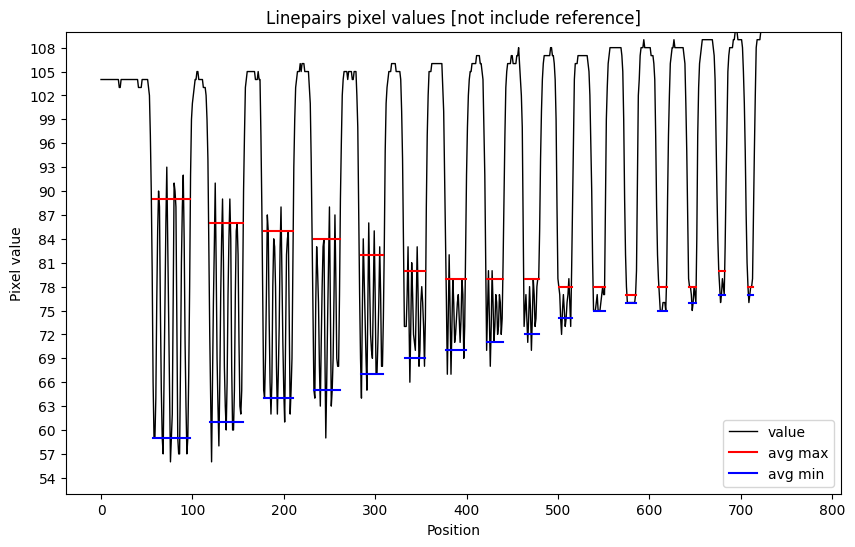

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(np.mean(focus, axis=0, dtype=np.int32), color="black", linewidth=1)
for (s1, s2), (_, max_v, min_v, _, _) in zip(pairs, res.values[1:]) :
    plt.plot([s1, s2], [max_v, max_v], color="red")
    plt.plot([s1, s2], [min_v, min_v], color="blue")
plt.yticks(np.arange(black, white+int(white*.1), 3));
plt.ylim(black+int(black*.1), white+int(white*.1))
plt.legend(["value", "avg max", "avg min"])
plt.title("Linepairs pixel values [not include reference]")
plt.ylabel("Pixel value")
plt.xlabel("Position");

In [30]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,104,50,54,100.000
1,1,89,59,30,55.556
2,2,86,61,25,46.296
3,3,85,64,21,38.889
4,4,84,65,19,35.185
5,5,82,67,15,27.778
6,6,80,69,11,20.370
7,7,79,70,9,16.667
8,8,79,71,8,14.815
9,9,79,72,7,12.963


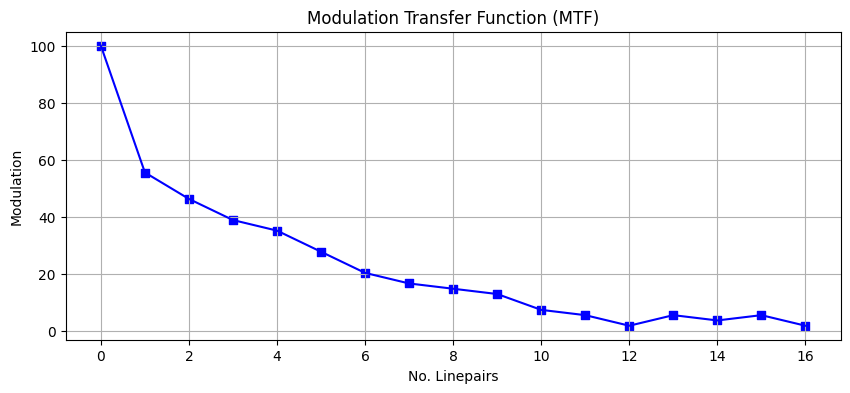

In [32]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");